![image.png](https://i.imgur.com/a3uAqnb.png)

# **🚀 Exercise: Build a Smoking Detection Classifier**
In this exercise, you will **train a binary classifier** to detect whether a person is **smoking** or **not smoking** using the `Smoking` dataset.

✅ **You will:**

1️⃣ Download the dataset.  
2️⃣ Build a **custom Dataset class** to handle image loading.  
3️⃣ Use **ResNet-18** as a pretrained model (can be accessed via: from torchvision.models import resnet18).  
4️⃣ Train the model and report **Training, Validation, and Testing Accuracy**.  
5️⃣ Display some **predictions along with images** at the end.  

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/smoking")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5


In [ ]:
import os
import glob
from tqdm import tqdm

# Define dataset path
dataset_path = os.path.join(path, "Training", "Training")
# Get all image paths
train_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Validation", "Validation")
# Get all image paths
valid_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Testing", "Testing")
# Get all image paths
test_image_paths = glob.glob(f"{dataset_path}/*.jpg")


train_labels = []
valid_labels = []
test_labels = []

for path in tqdm(train_image_paths):
    prefix  = path.split("/")[-1].split("_")[0]                 # "./Training(/)smoking_0007.jpg" → last element "smoking_0007.jpg"  → first element "smoking"
    label = 1 if prefix == "smoking" else 0                     # Assign label
    train_labels.append(label)                                  # Store label

for path in tqdm(valid_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    valid_labels.append(label)

for path in tqdm(test_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    test_labels.append(label)

100%|██████████| 224/224 [00:00<00:00, 871543.69it/s]


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class SmokingDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Transformations to apply

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get corresponding label

        # Load image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image and its label


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])


transform_valid_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

# Initialize datasets
train_dataset = SmokingDataset(train_image_paths, train_labels, transform=transform)
valid_dataset = SmokingDataset(valid_image_paths, valid_labels, transform=transform_valid_test)
test_dataset = SmokingDataset(test_image_paths, test_labels, transform=transform_valid_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0])


In [ ]:
import random

import torch
from torch.utils.data import Subset
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#load resnet pre trained model
#Task1:
model = models.resnet18(pretrained=True)

#Task2:
for param in model.parameters():
  param.require_grad=False

model.fc=nn.Linear(model.fc.in_features,out_features=2)

Epoch 0: loss = 12.793080
Epoch 1: loss = 7.887819
Epoch 2: loss = 5.561801
Epoch 3: loss = 3.419018
Epoch 4: loss = 2.983647
Epoch 5: loss = 1.829402
Epoch 6: loss = 1.623407
Epoch 7: loss = 0.973192
Epoch 8: loss = 0.799044
Epoch 9: loss = 0.799084


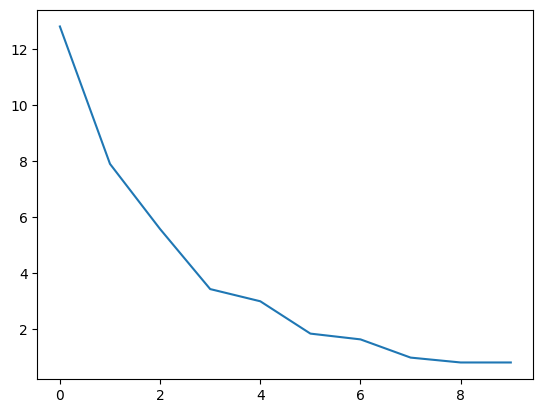

In [ ]:
#Task4:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=model.to(device)

num_epochs = 10
opt = optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.5)
lr_sch = optim.lr_scheduler.ExponentialLR(opt, 0.9, verbose = True)
ls = []
for epoch in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X,y = batch[0].to(device), batch[1].to(device)
    yhat = model(X)
    loss = F.cross_entropy(yhat, y)
    total_loss+=loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()

  lr_sch.step()
  ls.append(total_loss)
  print(f"Epoch {epoch}: loss = {total_loss:.6f}")


plt.plot(ls)


In [ ]:
# Initialize tensors to store accuracy counts and actual label counts for each class.
prediction_accuracy = torch.zeros(2)
actual_labels = torch.zeros(2)

def class_wise(y_preds, y):
    # Iterate over each actual label in the batch
    for label in y:
        # Increment the count for each actual label encountered
        actual_labels[label] += 1

    # Iterate over each unique label found in the actual labels
    for label in torch.unique(y):
        # Count correct predictions for the current label by comparing predictions with actual labels
        accurate = (y_preds == label).sum()
        # Store the count of correct predictions for the current label
        prediction_accuracy[label] = accurate




In [ ]:
#Task5:
with torch.no_grad():
  model.eval()
  total_accuracy=0
  total_samples=0
  for batch in valid_loader:
    X,y=batch[0].to(device),batch[1].to(device)
    total_samples+=len(X)
    #predict
    logits=model(X)
    #calculate accuracy
    y_preds=torch.argmax(logits,dim=1)
    class_wise(y_preds,y)
    accuracy=(y_preds==y).sum()

    total_accuracy+=accuracy



print(f"Accuracy of ResNet = {total_accuracy/float(total_samples) *100:.6f}%")

Accuracy of ResNet = 92.777786%


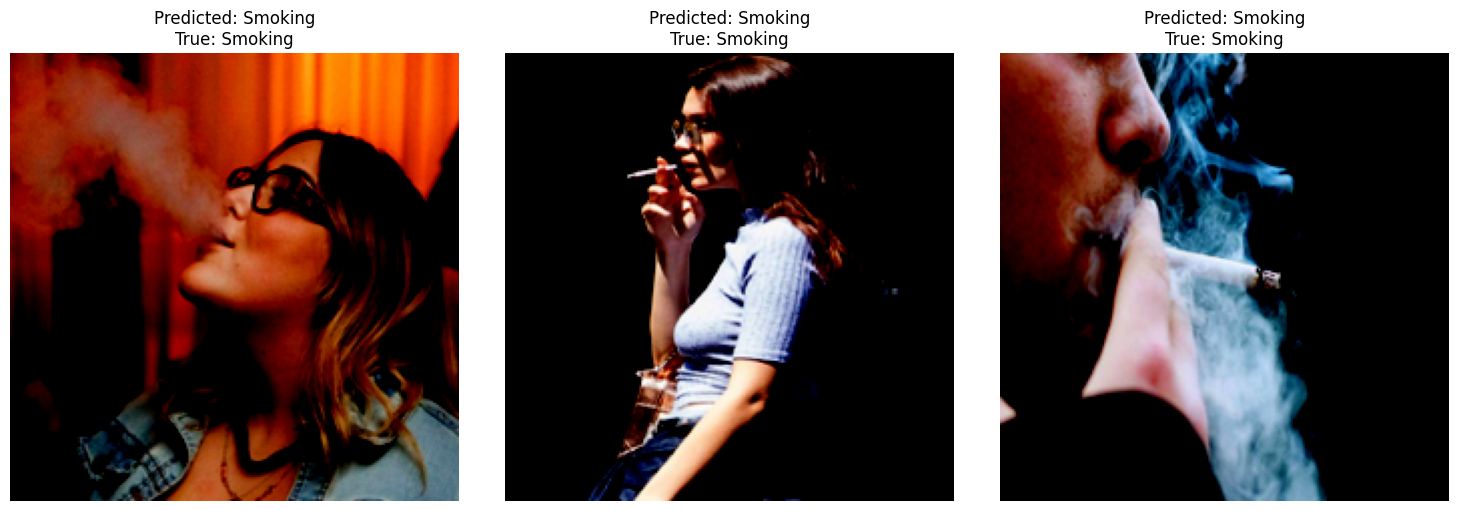

(224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming 'model' is your trained model and 'valid_loader' is your DataLoader for validation data
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fetch one batch of validation data
for images, labels in valid_loader:
    images, labels = images.to(device), labels.to(device)

    # Obtain predictions
    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)

    # Display images and predictions
    plt.figure(figsize=(15, 5))  # Set a larger figure size for subplots

    for i in range(min(len(images), 3)):  # Display first 3 images of the batch
        plt.subplot(1, 3, i + 1)
        img = images[i].cpu().numpy()  # Get the image data as a NumPy array
        img = np.transpose(img, (1, 2, 0))  # Reorder dimensions to (height, width, channels)
        plt.imshow(img) #Remove cmap='gray' since it's likely an RGB image
        plt.title(f'Predicted: {"Smoking" if predictions[i] == 1 else "Not Smoking"}\nTrue: {"Smoking" if labels[i] == 1 else "Not Smoking"}')
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    print(img.shape)
    break  # Only show one batch